In [1]:
import numpy as np
from sturdr.rcvr.rf_data_buffer import RfDataBuffer
from sturdr.channel.gps_l1ca_channel import gps_l1ca_code
from sturdr.dsp.tracking import NaturalFrequency, FLLassistedPLL_3rdOrder, PLL_2ndOrder, TrackingKF
from sturdr.dsp.gnss_signal import Correlate, CorrelateEPL, CodeNCO, CarrierNCO
from sturdr.dsp.discriminator import PllCostas, FllAtan2, DllNneml2
from sturdr.dsp.lock_detector import CodeLockDetector, PhaseLockDetector

# config
prn               = 7
in_file           = '../rfdata/class_ifen_8bit_20e6_if_5000445.88565834.bin'
sampling_freq     = 20e6
carrier_freq      = 1575.42e6
code_freq         = 1.023e6
code_len          = 1023
intermediate_freq = 5000445.88565834
is_complex        = False
bit_depth         = 8

# from acquisition
code                  = gps_l1ca_code(1)
acquired_doppler      = 1800
acquired_code_samples = 17414
signal_file           = RfDataBuffer(in_file, sampling_freq, is_complex, bit_depth)
signal_file.fseek(acquired_code_samples,0)

In [2]:

# initialize tracking filter
# w0p = NaturalFrequency(6.0,3)     # natural radian frequency for 3rd order PLL
# w0f = NaturalFrequency(0.1,2)   # natural radian frequency for 2nd order FLL
# w0d = NaturalFrequency(0.01,2)  # natural radian frequency for 2nd order DLL
w0p = NaturalFrequency(15,3)     # natural radian frequency for 3rd order PLL
w0f = NaturalFrequency(5,2)   # natural radian frequency for 2nd order FLL
w0d = NaturalFrequency(1,2)  # natural radian frequency for 2nd order DLL
kappa                 = code_freq / (2*np.pi*carrier_freq)
rem_carrier_phase     = 0.0
carrier_doppler       = 2 * np.pi * acquired_doppler
carrier_jitter        = 0.0
rem_code_phase        = 0.0
code_doppler          = kappa * carrier_doppler
dt                    = 0.001
ifreq_rad             = 2 * np.pi * intermediate_freq

# create tracking kalman filter
kf = TrackingKF(w0p, w0f, w0d, 
                doppler=carrier_doppler,
                nominal_carrier_freq=2*np.pi*carrier_freq, 
                nominal_code_freq=code_freq,
                intermediate_freq=ifreq_rad, 
                T=dt)

# create tracking loop filter
jitter_accumulator = 0.0
doppler_accumulator = carrier_doppler
chip_accumulator = 0.0

# correlator taps
tap_spacings = (np.arange(-1.1,1.11,0.1) * sampling_freq/code_freq).astype(int)
samples_per_chip = tap_spacings[-1]
noise_tap = np.round(code_len / 2 * sampling_freq/code_freq).astype(int)

# lcok detector init
A2 = 0
n2 = 0
i_carrier = 0
q_carrier = 0

# initialize output
N = 5000
i_correlators = np.zeros((23,N))
q_correlators = np.zeros((23,N))
carrier_doppler_save = np.zeros(N)
code_doppler_save = np.zeros(N)
cn0_mag = np.zeros(N)
carrier_lock = np.zeros(N)
rem_code_phase_save = np.zeros(N)

In [3]:
# run tracking loop
for i in range(N):
    # upsample code to determine number of samples to read
    new_code, rem_code_phase = CodeNCO(code, 
                                       sampling_freq, 
                                       code_freq + code_doppler, 
                                       code_len, 
                                       rem_code_phase)
    new_len = new_code.size
    
    # run carrier nco (same number of samples from code nco)
    new_carrier, rem_carrier_phase = CarrierNCO(sampling_freq, 
                                                ifreq_rad + carrier_doppler, 
                                                carrier_jitter, 
                                                new_len, 
                                                rem_carrier_phase)
    
    # read in signal samples (same number of samples from code nco)
    rfdata = signal_file.fread(new_len)
    
    # correlate with tap spacing of 0.5 chips
    signal = rfdata * new_carrier
    idx = np.arange(new_len)
    j = 0
    for t in tap_spacings:
        if t == 0:
            half_len = int(new_len / 2)
            IP_1, QP_1 = Correlate(signal[:half_len], new_code[:half_len])
            IP_2, QP_2 = Correlate(signal[half_len:], new_code[half_len:])
            IP = IP_1 + IP_2
            QP = QP_1 + QP_2
            i_correlators[j,i] = IP
            q_correlators[j,i] = QP
        else:
            i_correlators[j,i], q_correlators[j,i] = Correlate(signal, new_code[(idx + t) % new_len])
            if t == 9: #t == samples_per_chip:
                IE = i_correlators[j,i]
                QE = q_correlators[j,i]
            elif t == -9: #t == -samples_per_chip:
                IL = i_correlators[j,i]
                QL = q_correlators[j,i]
        j += 1
    
    # calculate discriminators
    phase_err = PllCostas(IP, QP)                     # [rad]
    freq_err = FllAtan2(IP_1, IP_2, QP_1, QP_2, dt/2) # [rad/s]
    chip_err = DllNneml2(IE, QE, IL, QL)               # [chip]
    
    # code lock & C/N0 estimator
    IN, QN = Correlate(signal, new_code[(idx + 10000) % new_len])
    code_lock, cn0_mag[i], A2, n2 = CodeLockDetector(A2, n2, IP, QP, IN, QN, dt)
    carrier_lock[i], i_carrier, q_carrier = PhaseLockDetector(i_carrier, q_carrier, IP, QP)
    
    # run tracking kalman filter
    t = new_len / sampling_freq
    kf.UpdateIntegrationTime(t)
    kf.UpdateCn0(cn0_mag[i])
    x = kf.Run(phase_err, freq_err, chip_err)  
    rem_carrier_phase = np.remainder(x[0], 2*np.pi)
    carrier_doppler = x[1]
    carrier_jitter = x[2]
    rem_code_phase = np.remainder(x[3], code_len)
    code_doppler = x[4] + kappa * (x[1] + dt * x[2])
    x[0] = rem_carrier_phase
    x[3] = rem_code_phase
    
    # # run tracking loop filter
    # carrier_doppler, jitter_accumulator, doppler_accumulator = FLLassistedPLL_3rdOrder(
    #     phase_err, freq_err, jitter_accumulator, doppler_accumulator, dt, w0p, w0f
    # )
    # code_doppler, chip_accumulator = PLL_2ndOrder(chip_err, chip_accumulator, dt, w0d)
    # code_doppler += kappa * carrier_doppler
    
    carrier_doppler_save[i] = carrier_doppler / (2*np.pi)
    code_doppler_save[i] = code_doppler
    rem_code_phase_save[i] = rem_code_phase
    if rem_code_phase_save[i] > 1023/2:
        rem_code_phase_save[i] -= 1023


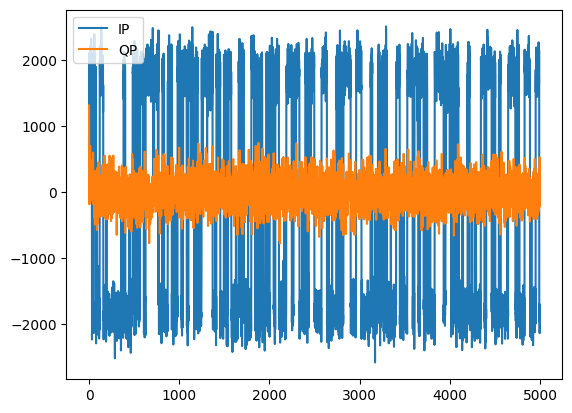

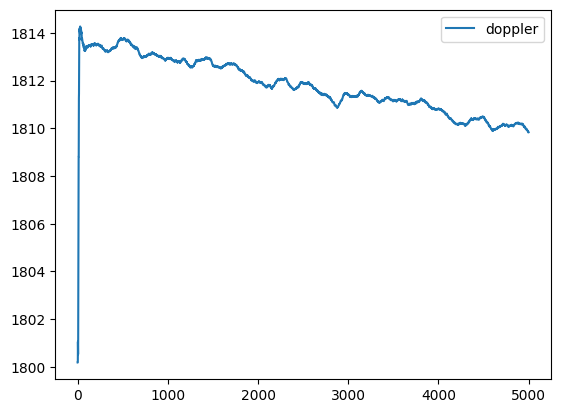

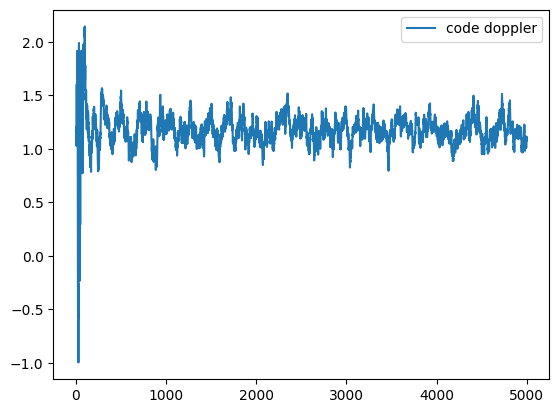

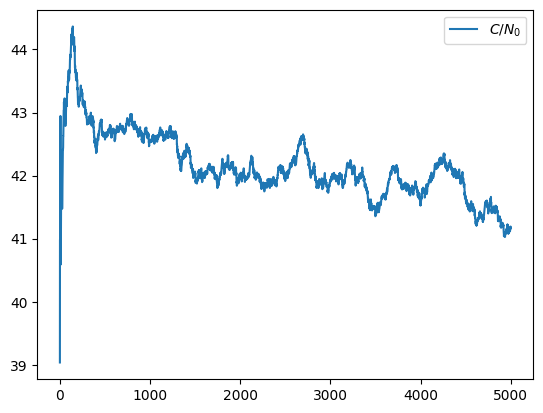

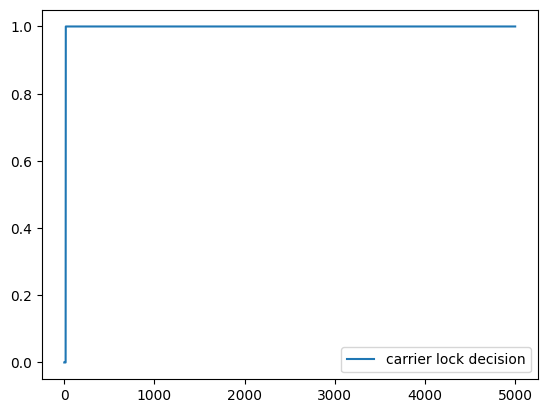

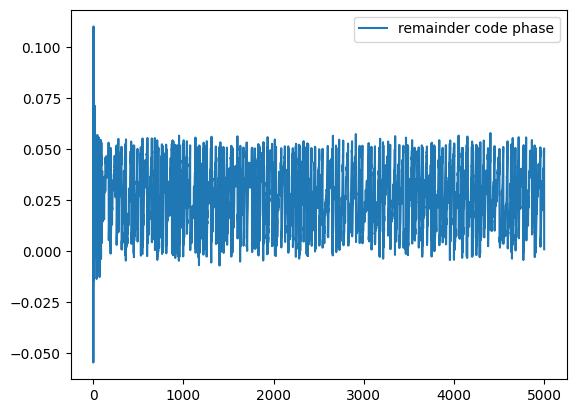

In [4]:
import matplotlib.pyplot as plt

# plot IP and QP
plt.figure()
plt.plot(i_correlators[11,:], label='IP')
plt.plot(q_correlators[11,:], label='QP')
plt.legend()

# plot carrier doppler
plt.figure()
plt.plot(carrier_doppler_save, label='doppler')
plt.legend()

# plot code doppler
plt.figure()
plt.plot(code_doppler_save, label='code doppler')
plt.legend()

# plot carrier-to-noise density ratio
plt.figure()
plt.plot(10*np.log10(cn0_mag), label='$C/N_0$')
plt.legend()

# plot carrier lock decision
plt.figure()
plt.plot(carrier_lock, label='carrier lock decision')
plt.legend()

# plot remainder code phase
plt.figure()
plt.plot(rem_code_phase_save, label='remainder code phase')
plt.legend()

plt.show()

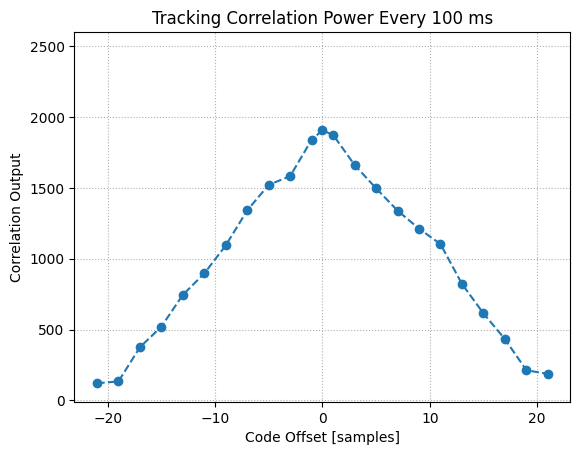

In [5]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

correlator_mag = np.sqrt(i_correlators**2 + q_correlators**2)
f, ax = plt.subplots()
l, = ax.plot(tap_spacings, correlator_mag[:,0], linestyle='--', marker='o')
ax.set(xlabel="Code Offset [samples]", 
       ylabel="Correlation Output", 
       ylim=(np.min(correlator_mag)-10,np.max(correlator_mag)+10), 
       title="Tracking Correlation Power Every 100 ms")
plt.grid(linestyle = ':')

def animate(i):
    l.set_data(tap_spacings, correlator_mag[:,100*i])

ani = FuncAnimation(f, animate, frames=int(N/100))
HTML(ani.to_jshtml())